# Analysis for China wage vs. education data

#### Since R cannot be ran on normal VS code, I had to install visual studio code insider for it!

## Datasets used

From Dropbox: China-Education-Wages -> Data -> CFPS Data 2010-2016

Downloaded:
- 2010 Egnlish -> ecfps2010adult_112014.dta     
  - Renamed 2010adult.dta
- 2012 Egnlish -> ecfps2012adultcombine…015.dta     
  - Renamed 2012adult.dta
- 2014 English -> ecfps2014adult_170630.dta     
  - Renamed 2014adult.dta
- Mincer16 -> Mincer16.csv 

All 4 datasets were put within one folder named $CFPSdata$ in the same layer as this jupyter notebook.

In [1]:
library(knitr)
library(xtable)
library(broom)
library(dplyr)
library(tidyverse)
library(ggplot2)
library(stargazer)
library(lubridate)
library(haven)
library(ineq)
library(PerformanceAnalytics)
library(gglorenz)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.0
v readr   1.4.0     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are

## Manipulating data

### Read Data

In [2]:
data10 = read_dta("./CFPSdata/2010adult.dta")
data10 = filter(data10, !qc1 < 0)
data12 = read_dta("./CFPSdata/2012adult.dta")
data12 = filter(data12, !sch2012 < 0)
data14 = read_dta("./CFPSdata/2014adult.dta")
data14 = filter(data14, !pw1r < 0)
data16 = read.csv("./CFPSdata/Mincer16.csv")

### Adding education and year dummies to the data, then combining them into one dataframe

In [3]:
pinc <- function(df) {
    categorize <- 
        df %>%
        group_by(rinc) %>%
        tally()
    categorize = categorize[order(categorize$rinc), ]
    key = categorize$rinc
    pinc = c()
    sum_so_far = 0
    total = nrow(df)
    categorize$pinc = 0
    for (row in 1:nrow(categorize)) {
      sum_so_far = sum_so_far + categorize[row, 'n']
      categorize[row, 'pinc'] = (sum_so_far - (0.5 * categorize[row, 'n'])) / total
    }
    ordered_combined <- df[order(df$rinc), ]
    ordered_combined$pinc = 0
    current_rinc = 0
    current_pinc = 0
    current_row = 0
    for (row in 1:nrow(ordered_combined)) {
      rinc = ordered_combined[row, 'rinc']
      if (rinc != current_rinc) {
        current_row = current_row + 1
        current_rinc = rinc
        current_pinc = categorize[current_row, 'pinc']
      }
      ordered_combined[row, 'pinc'] = current_pinc
    }
    ordered_combined$lnpinc = log(ordered_combined$pinc)
    return(ordered_combined)
}

In [4]:
mincer10 = data.frame(
  income = data10$income, 
  age = data10$qa1age,
  gender = data10$gender,
  urban = data10$urban,
  prov = data10$provcd,
  ethnic = data10$qa5code,
  married = 0,
  party = 0,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 1,
  y12 = 0,
  y14 = 0,
  y16 = 0)

for (row in 1:nrow(data10)) {
  marriage = data10[row, "qe1"]
  if (marriage == 2) {
    mincer10[row, "married"] = 1
  }
  party = data10[row, "qa7_s_1"]
  if (party == 1) {
    mincer10[row, "party"] = 1
  }
  edu = data10[row, "qc1"]
  if (edu == 1) {
    mincer10[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer10[row, "primary"] = 1
  } else if (edu == 3) {
    mincer10[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer10[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer10[row, "postsecondary"] = 1
  }
}
mincer10 = filter(mincer10, !is.na(income) & income >= 0)

mincer10_urban = filter(mincer10, urban == 1)
mincer10_rural = filter(mincer10, urban == 0)
mincer10_female_urban = filter(mincer10_urban, gender == 1)
mincer10_female_rural = filter(mincer10_rural, gender == 1)
mincer10_male_urban = filter(mincer10_urban, gender == 0)
mincer10_male_rural = filter(mincer10_rural, gender == 0)

mincer10$rinc = mincer10$income / mean(mincer10$income)

mincer10_urban$rinc = mincer10_urban$income / mean(mincer10_urban$income)
mincer10_rural$rinc = mincer10_rural$income / mean(mincer10_rural$income)
mincer10_female_urban$rinc = mincer10_female_urban$income / mean(mincer10_female_urban$income)
mincer10_female_rural$rinc = mincer10_female_rural$income / mean(mincer10_female_rural$income)
mincer10_male_urban$rinc = mincer10_male_urban$income / mean(mincer10_male_urban$income)
mincer10_male_rural$rinc = mincer10_male_rural$income / mean(mincer10_male_rural$income)

In [5]:
mincer10 <- pinc(mincer10)

mincer10_urban <- pinc(mincer10_urban)

mincer10_rural <- pinc(mincer10_rural)

mincer10_female_urban <- pinc(mincer10_female_urban)

mincer10_female_rural <- pinc(mincer10_female_rural)

mincer10_male_urban <- pinc(mincer10_male_urban)

mincer10_male_rural <- pinc(mincer10_male_rural)

In [6]:
mincer12 = data.frame(
  income = data12$income, 
  age = data12$cfps2012_age,
  gender = data12$cfps2012_gender,
  urban = data12$urban12,
  prov = data12$provcd,
  ethnic = data12$qa701code,
  married = 0,
  party = data12$sn401,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 0,
  y12 = 1,
  y14 = 0,
  y16 = 0)

for (row in 1:nrow(data12)) {
  marriage = data12[row, "qe104"]
  if (marriage == 2) {
    mincer12[row, "married"] = 1
  }
  edu = data12[row, "sch2012"]
  if (edu == 1) {
    mincer12[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer12[row, "primary"] = 1
  } else if (edu == 3) {
    mincer12[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer12[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer12[row, "postsecondary"] = 1
  }
}
mincer12 = filter(mincer12, !is.na(income))

mincer12_urban = filter(mincer12, urban == 1)
mincer12_rural = filter(mincer12, urban == 0)
mincer12_female_urban = filter(mincer12_urban, gender == 1)
mincer12_female_rural = filter(mincer12_rural, gender == 1)
mincer12_male_urban = filter(mincer12_urban, gender == 0)
mincer12_male_rural = filter(mincer12_rural, gender == 0)

mincer12$rinc = mincer12$income / mean(mincer12$income)

mincer12_urban$rinc = mincer12_urban$income / mean(mincer12_urban$income)
mincer12_rural$rinc = mincer12_rural$income / mean(mincer12_rural$income)
mincer12_female_urban$rinc = mincer12_female_urban$income / mean(mincer12_female_urban$income)
mincer12_female_rural$rinc = mincer12_female_rural$income / mean(mincer12_female_rural$income)
mincer12_male_urban$rinc = mincer12_male_urban$income / mean(mincer12_male_urban$income)
mincer12_male_rural$rinc = mincer12_male_rural$income / mean(mincer12_male_rural$income)

In [12]:
mincer12 <- pinc(mincer12)

mincer12_urban <- pinc(mincer12_urban)

mincer12_rural <- pinc(mincer12_rural)

mincer12_female_urban <- pinc(mincer12_female_urban)

mincer12_female_rural <- pinc(mincer12_female_rural)

mincer12_male_urban <- pinc(mincer12_male_urban)

mincer12_male_rural <- pinc(mincer12_male_rural)

In [7]:
mincer14 = data.frame(
  income = data14$p_income, 
  age = data14$cfps2014_age,
  gender = data14$cfps_gender,
  urban = data14$urban14,
  prov = data14$provcd14,
  ethnic = data14$cfps_minzu,
  married = 0,
  party = data14$pn401a,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 0,
  y12 = 0,
  y14 = 1,
  y16 = 0)

for (row in 1:nrow(data14)) {
  marriage = data14[row, "qea0"]
  if (marriage == 2) {
    mincer14[row, "married"] = 1
  }
  edu = data14[row, "pw1r"]
  if (edu == 1) {
    mincer14[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer14[row, "primary"] = 1
  } else if (edu == 3) {
    mincer14[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer14[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer14[row, "postsecondary"] = 1
  }
}
mincer14 = filter(mincer14, !is.na(income))

mincer14_urban = filter(mincer14, urban == 1)
mincer14_rural = filter(mincer14, urban == 0)
mincer14_female_urban = filter(mincer14_urban, gender == 1)
mincer14_female_rural = filter(mincer14_rural, gender == 1)
mincer14_male_urban = filter(mincer14_urban, gender == 0)
mincer14_male_rural = filter(mincer14_rural, gender == 0)

mincer14$rinc = mincer14$income / mean(mincer14$income)

mincer14_urban$rinc = mincer14_urban$income / mean(mincer14_urban$income)
mincer14_rural$rinc = mincer14_rural$income / mean(mincer14_rural$income)
mincer14_female_urban$rinc = mincer14_female_urban$income / mean(mincer14_female_urban$income)
mincer14_female_rural$rinc = mincer14_female_rural$income / mean(mincer14_female_rural$income)
mincer14_male_urban$rinc = mincer14_male_urban$income / mean(mincer14_male_urban$income)
mincer14_male_rural$rinc = mincer14_male_rural$income / mean(mincer14_male_rural$income)

In [14]:
mincer14 <- pinc(mincer14)

mincer14_urban <- pinc(mincer14_urban)

mincer14_rural <- pinc(mincer14_rural)

mincer14_female_urban <- pinc(mincer14_female_urban)

mincer14_female_rural <- pinc(mincer14_female_rural)

mincer14_male_urban <- pinc(mincer14_male_urban)

mincer14_male_rural <- pinc(mincer14_male_rural)

In [15]:
mincer16 = data.frame(
  income = data16$income, 
  age = data16$age,
  gender = data16$gender,
  urban = data16$urban16,
  prov = data16$provcd16,
  ethnic = data16$ethnic,
  married = data16$married,
  party = data16$party,
  postsecondary = data16$postsecondary,
  seniorsecondary = data16$seniorsecondary, 
  juniorsecondary = data16$juniorsecondary, 
  primary = data16$primary, 
  illiterate = data16$illiterate,
  y10 = 0,
  y12 = 0,
  y14 = 0,
  y16 = 1)
mincer16 = filter(mincer16, !is.na(income))

mincer16_urban = filter(mincer16, urban == 1)
mincer16_rural = filter(mincer16, urban == 0)
mincer16_female_urban = filter(mincer16_urban, gender == 1)
mincer16_female_rural = filter(mincer16_rural, gender == 1)
mincer16_male_urban = filter(mincer16_urban, gender == 0)
mincer16_male_rural = filter(mincer16_rural, gender == 0)

mincer16$rinc = mincer16$income / mean(mincer16$income)

mincer16_urban$rinc = mincer16_urban$income / mean(mincer16_urban$income)
mincer16_rural$rinc = mincer16_rural$income / mean(mincer16_rural$income)
mincer16_female_urban$rinc = mincer16_female_urban$income / mean(mincer16_female_urban$income)
mincer16_female_rural$rinc = mincer16_female_rural$income / mean(mincer16_female_rural$income)
mincer16_male_urban$rinc = mincer16_male_urban$income / mean(mincer16_male_urban$income)
mincer16_male_rural$rinc = mincer16_male_rural$income / mean(mincer16_male_rural$income)

In [16]:
mincer16 <- pinc(mincer16)

mincer16_urban <- pinc(mincer16_urban)

mincer16_rural <- pinc(mincer16_rural)

mincer16_female_urban <- pinc(mincer16_female_urban)

mincer16_female_rural <- pinc(mincer16_female_rural)

mincer16_male_urban <- pinc(mincer16_male_urban)

mincer16_male_rural <- pinc(mincer16_male_rural)

In [9]:
combined = full_join(mincer10, full_join(mincer12, full_join(mincer14, mincer16)))
combined$lninc = log(combined$income)
combined$lnrinc = log(combined$rinc)

urban = full_join(mincer10_urban, full_join(mincer12_urban, full_join(mincer14_urban, mincer16_urban)))
urban$lninc = log(urban$income)
urban$lnrinc = log(urban$rinc)


rural = full_join(mincer10_rural, full_join(mincer12_rural, full_join(mincer14_rural, mincer16_rural)))
rural$lninc = log(rural$income)
rural$lnrinc = log(rural$rinc)


female_urban = full_join(mincer10_female_urban, full_join(mincer12_female_urban, full_join(mincer14_female_urban, mincer16_female_urban)))
female_urban$lninc = log(female_urban$income)
female_urban$lnrinc = log(female_urban$rinc)


female_rural = full_join(mincer10_female_rural, full_join(mincer12_female_rural, full_join(mincer14_female_rural, mincer16_female_rural)))
female_rural$lninc = log(female_rural$income)
female_rural$lnrinc = log(female_rural$rinc)


male_urban = full_join(mincer10_male_urban, full_join(mincer12_male_urban, full_join(mincer14_male_urban, mincer16_male_urban)))
male_urban$lninc = log(male_urban$income)
male_urban$lnrinc = log(male_urban$rinc)

male_rural = full_join(mincer10_male_rural, full_join(mincer12_male_rural, full_join(mincer14_male_rural, mincer16_male_rural)))
male_rural$lninc = log(male_rural$income)
male_rural$lnrinc = log(male_rural$rinc)

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc")

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc")

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc")

Warning message in .fn(vec_data(.x), ...):
"NaNs produced"
Warning message in log(combined$rinc):
"NaNs produced"
Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc")

Joining, by = c("income", "age", "gender", "urban", "prov"

### Computing Lorenz curves for combined, male, and female for each year

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.

Saving 7 x 7 in image

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



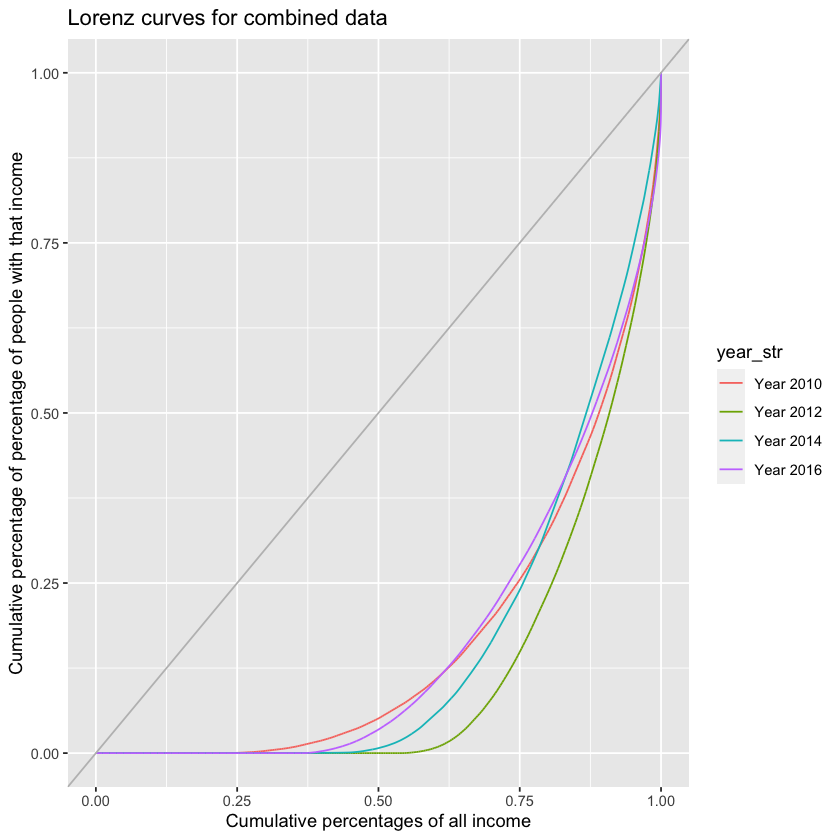

Saving 7 x 7 in image

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



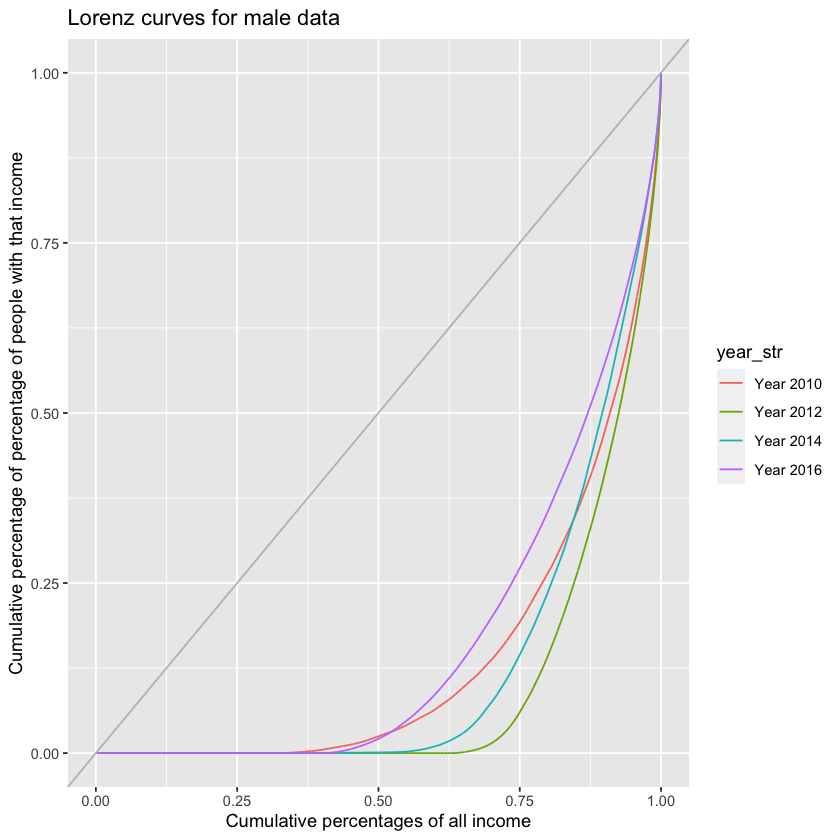

Saving 7 x 7 in image

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



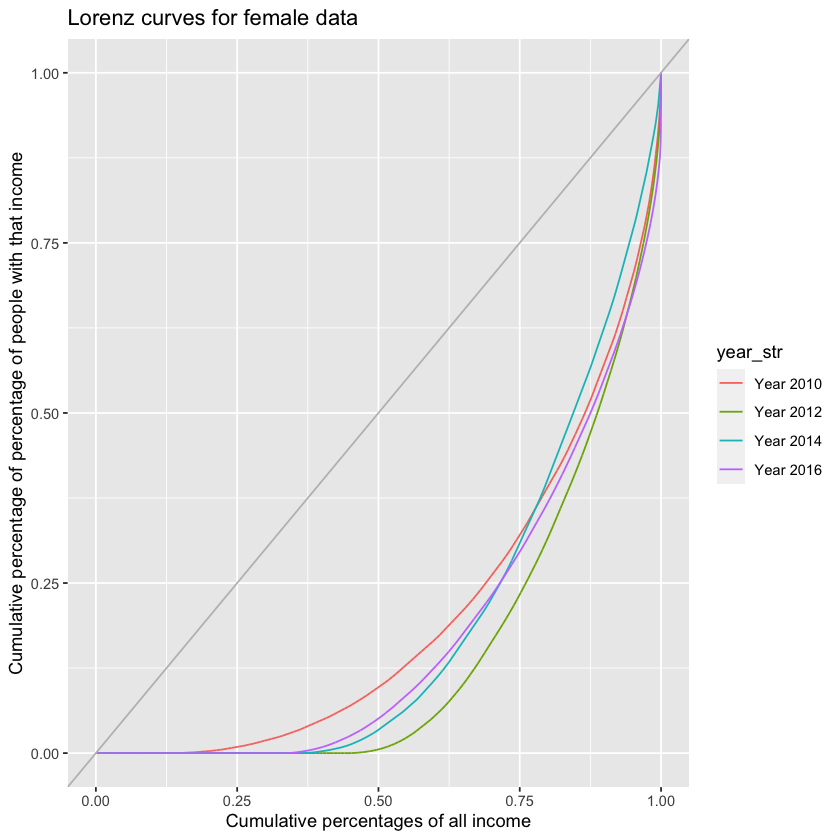

In [10]:
lorenz_combined = filter(combined, income >=0)

lorenz_combined$year_str[lorenz_combined$y10 == 1] <- "Year 2010"
lorenz_combined$year_str[lorenz_combined$y12 == 1] <- "Year 2012"
lorenz_combined$year_str[lorenz_combined$y14 == 1] <- "Year 2014"
lorenz_combined$year_str[lorenz_combined$y16 == 1] <- "Year 2016"

lorenz_male = filter(lorenz_combined, gender == 0)
lorenz_female = filter(lorenz_combined, gender == 1)

ggplot(lorenz_combined, aes(x = income, colour = year_str)) + 
  stat_lorenz() + 
  geom_abline(color = "grey") +
  labs(x = "Cumulative percentages of all income", 
       y = "Cumulative percentage of percentage of people with that income", 
       title = "Lorenz curves for combined data")

ggsave("LorenzCurves/Lorenz_curve_combined.png")

ggplot(lorenz_male, aes(x = income, colour = year_str)) + 
  stat_lorenz() + 
  geom_abline(color = "grey") +
  labs(x = "Cumulative percentages of all income", 
       y = "Cumulative percentage of percentage of people with that income", 
       title = "Lorenz curves for male data")

ggsave("LorenzCurves/Lorenz_curve_male.png")

ggplot(lorenz_female, aes(x = income, colour = year_str)) + 
  stat_lorenz() + 
  geom_abline(color = "grey") +
  labs(x = "Cumulative percentages of all income", 
       y = "Cumulative percentage of percentage of people with that income", 
       title = "Lorenz curves for female data")

ggsave("LorenzCurves/Lorenz_curve_female.png")

In [27]:
sprintf("Combined: %f, %f, %f, %f", Gini(mincer10$inc), Gini(mincer12$inc), Gini(mincer14$inc), Gini(mincer16$inc))
sprintf("Urban: %f, %f, %f, %f", Gini(mincer10_urban$inc), Gini(mincer12_urban$inc), Gini(mincer14_urban$inc), Gini(mincer16_urban$inc))
sprintf("Rural: %f, %f, %f, %f", Gini(mincer10_rural$inc), Gini(mincer12_rural$inc), Gini(mincer14_rural$inc), Gini(mincer16_rural$inc))
sprintf("Female Urban: %f, %f, %f, %f", Gini(mincer10_female_urban$inc), Gini(mincer12_female_urban$inc), Gini(mincer14_female_urban$inc), Gini(mincer16_female_urban$inc))
sprintf("Female Rural: %f, %f, %f, %f", Gini(mincer10_female_rural$inc), Gini(mincer12_female_rural$inc), Gini(mincer14_female_rural$inc), Gini(mincer16_female_rural$inc))
sprintf("Male Urban: %f, %f, %f, %f", Gini(mincer10_male_urban$inc), Gini(mincer12_male_urban$inc), Gini(mincer14_male_urban$inc), Gini(mincer16_male_urban$inc))
sprintf("male Rural: %f, %f, %f, %f", Gini(mincer10_male_rural$inc), Gini(mincer12_male_rural$inc), Gini(mincer14_male_rural$inc), Gini(mincer16_male_rural$inc))

[1] "Combined: 0.672533, 0.760226, 0.727774, 0.668838"

[1] "Urban: 0.623614, 0.689707, 0.782423, 0.601765"

[1] "Rural: 0.685016, 0.814318, 0.845863, 0.736257"

[1] "Female Urban: 0.562609, 0.648615, 0.702627, 0.579804"

[1] "Female Rural: 0.605905, 0.741049, 0.784623, 0.724712"

[1] "Male Urban: 0.668056, 0.717524, 0.862371, 0.612263"

[1] "male Rural: 0.744830, 0.879955, 0.896217, 0.719399"

## Running the descriptive analysis for the all of the sub populations

### For combined data

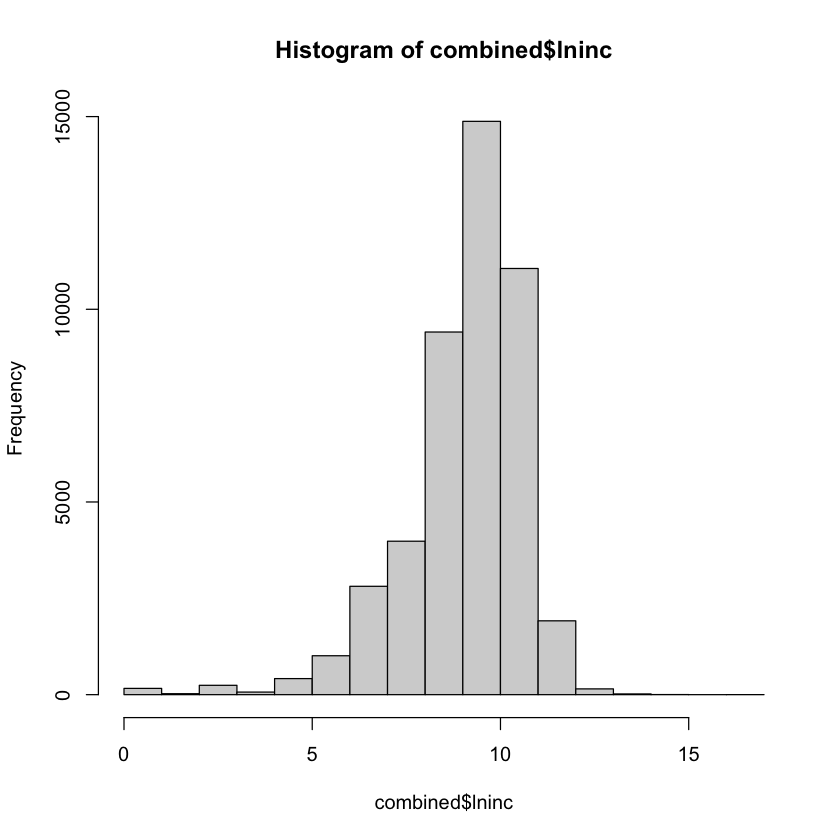

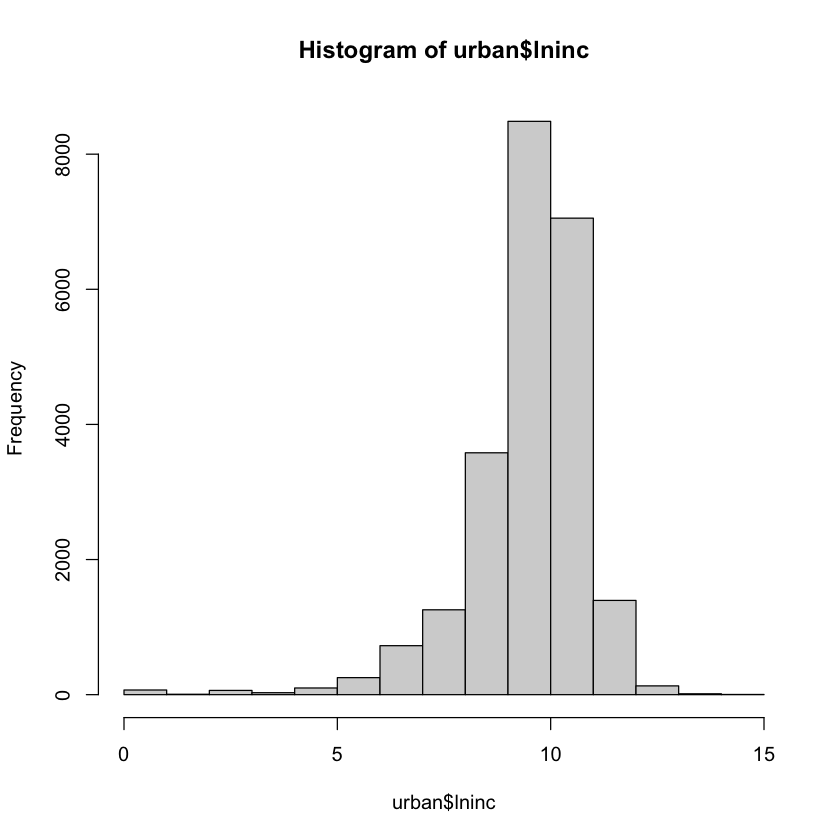

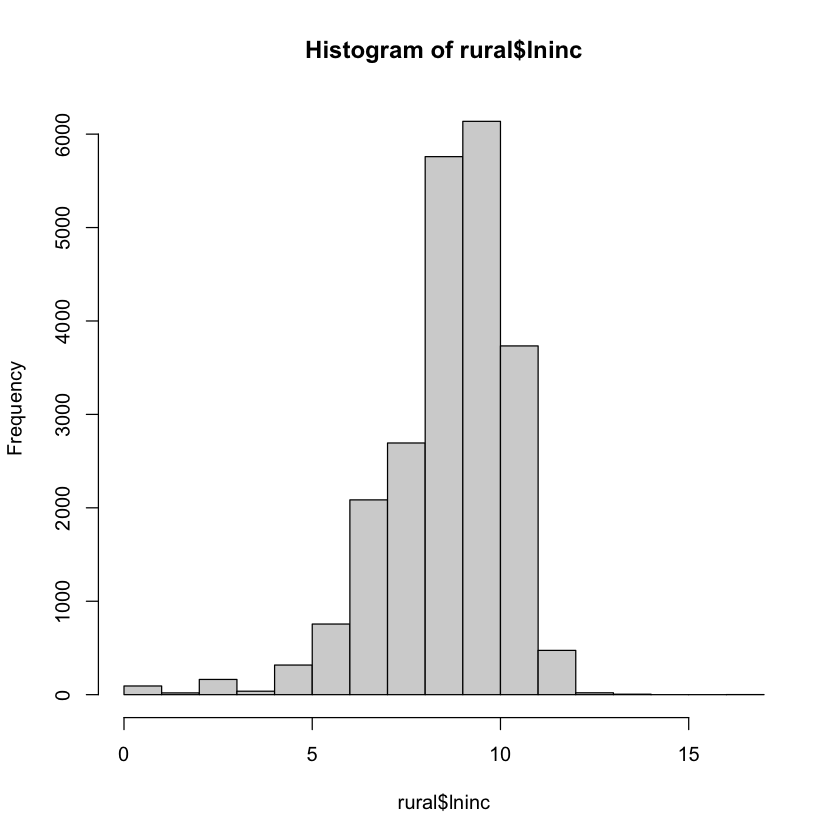

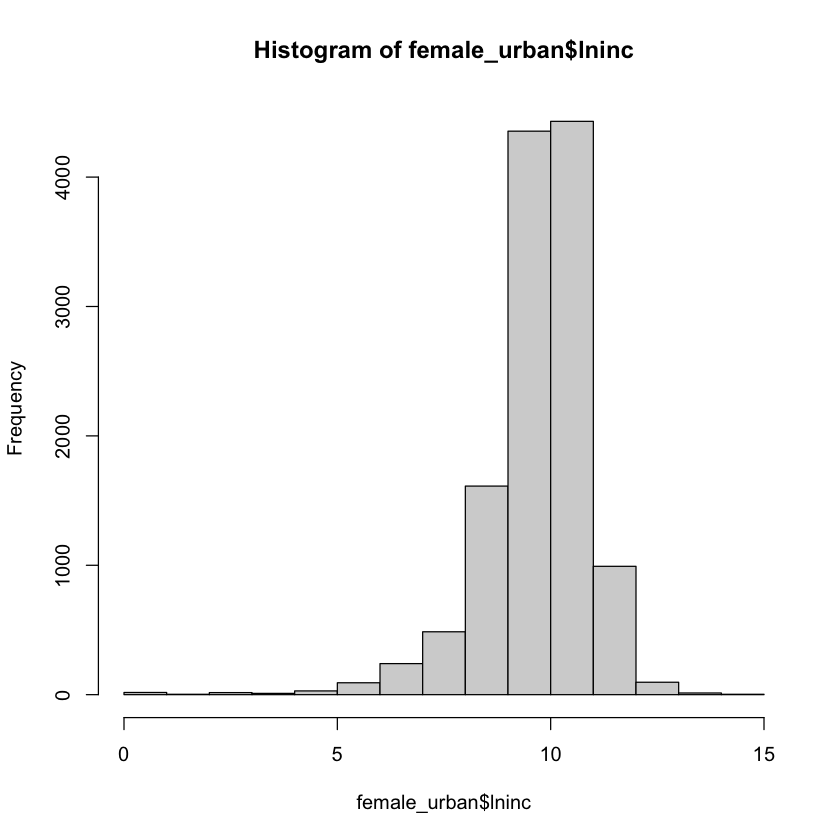

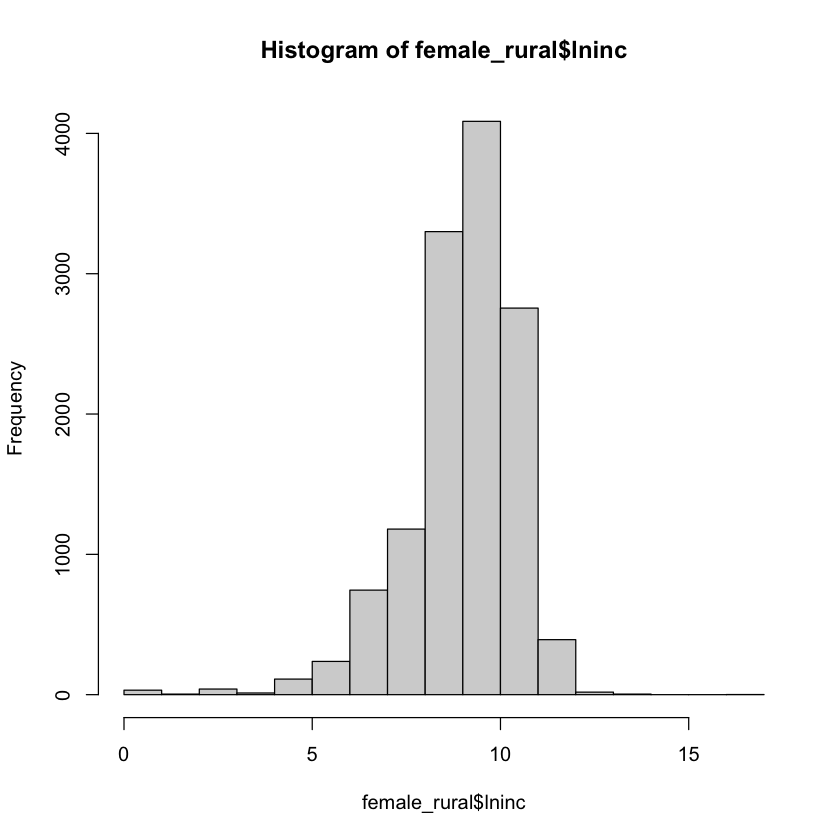

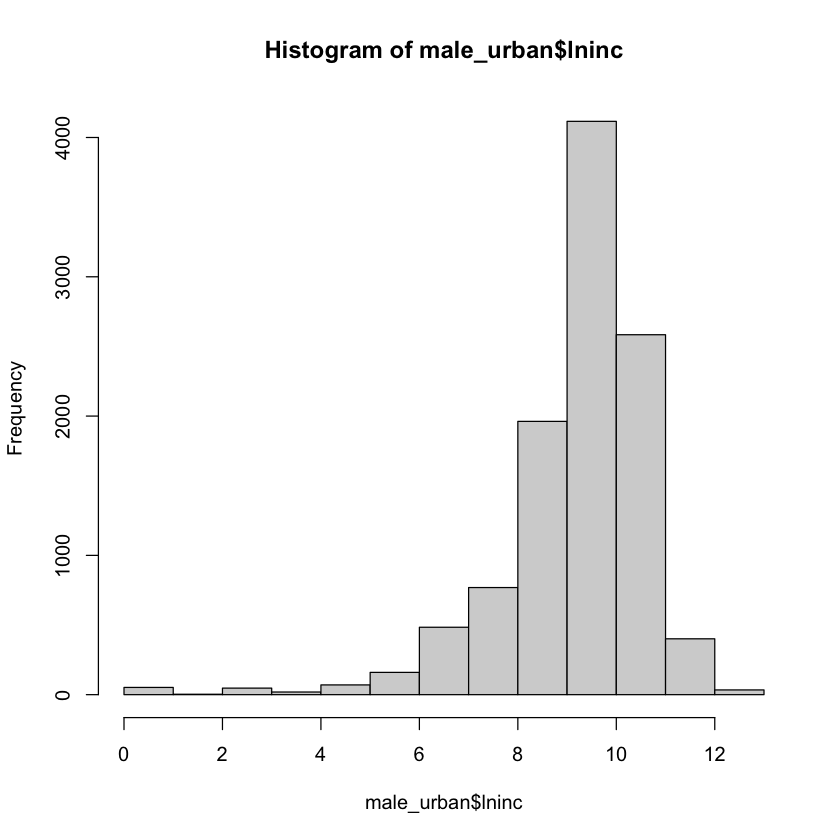

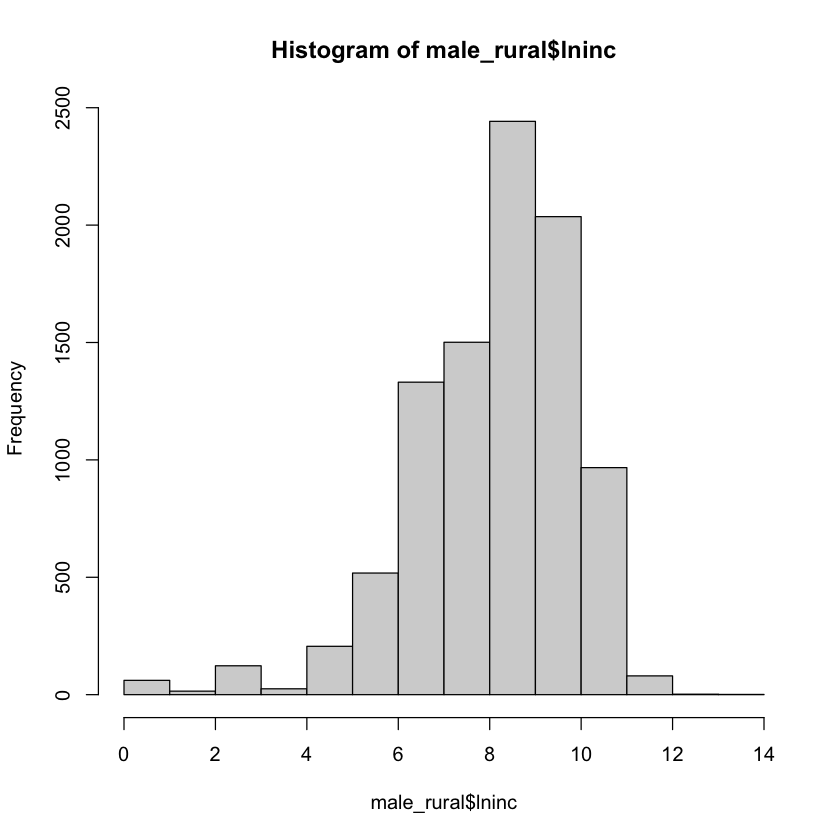

In [36]:
hist(combined$lninc)
hist(urban$lninc)
hist(rural$lninc)
hist(female_urban$lninc)
hist(female_rural$lninc)
hist(male_urban$lninc)
hist(male_rural$lninc)


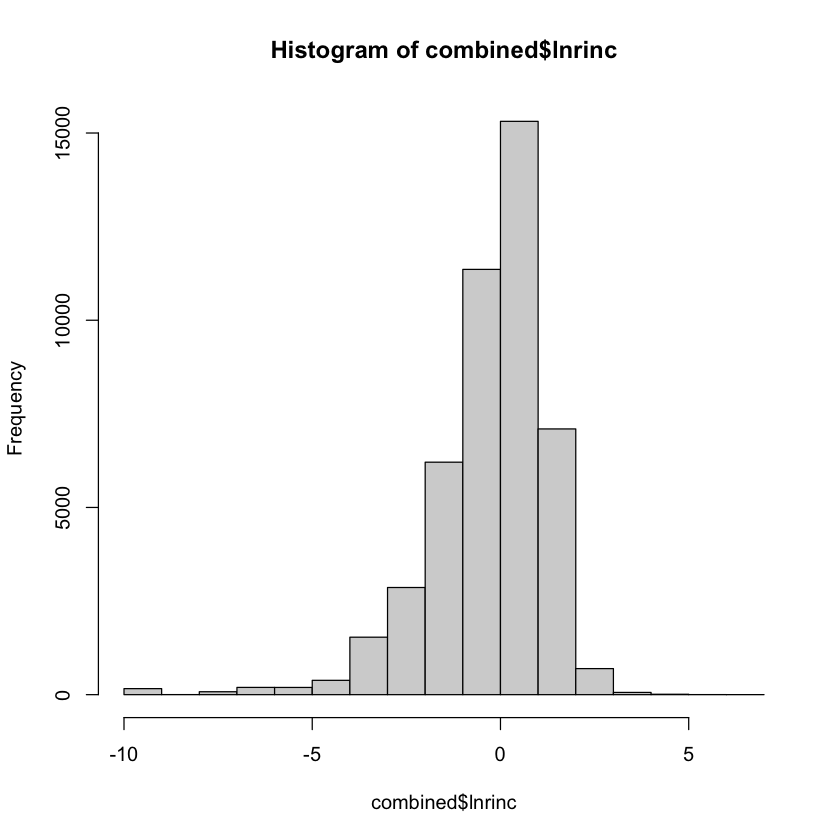

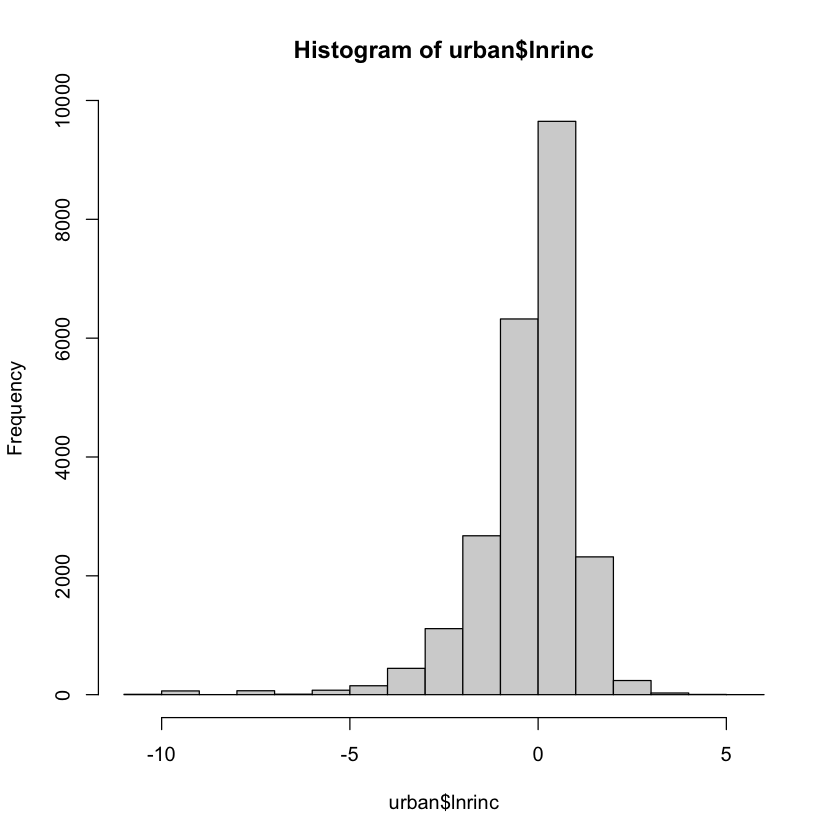

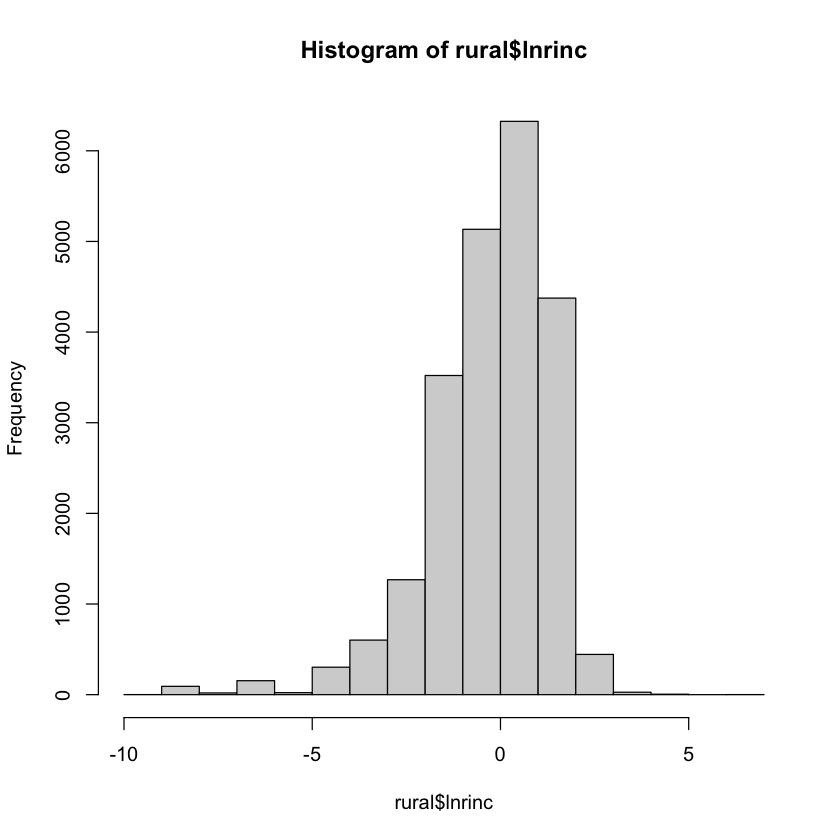

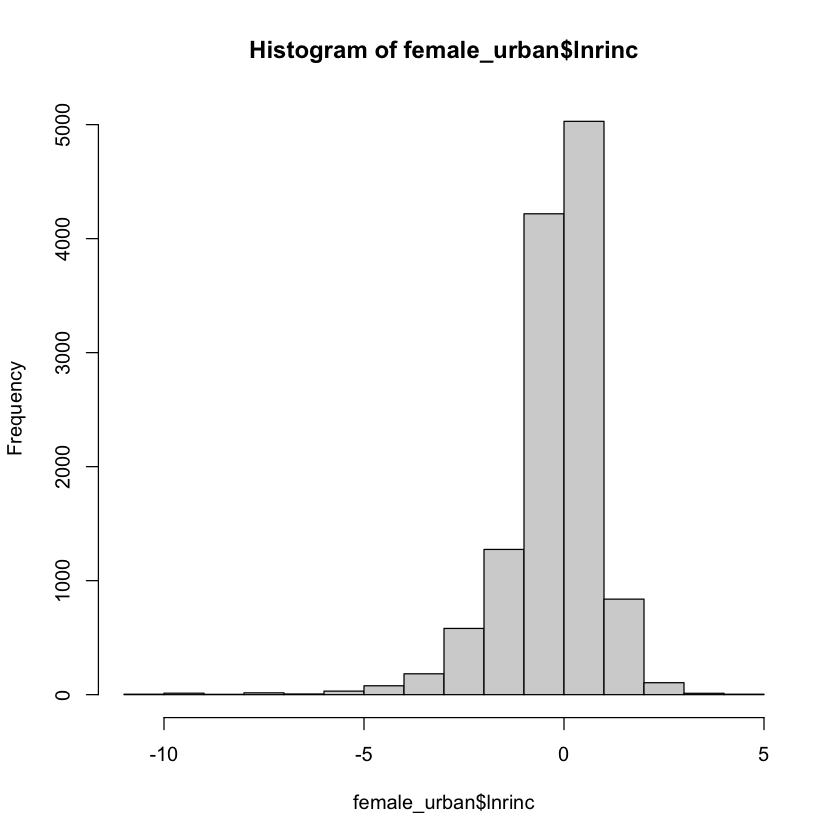

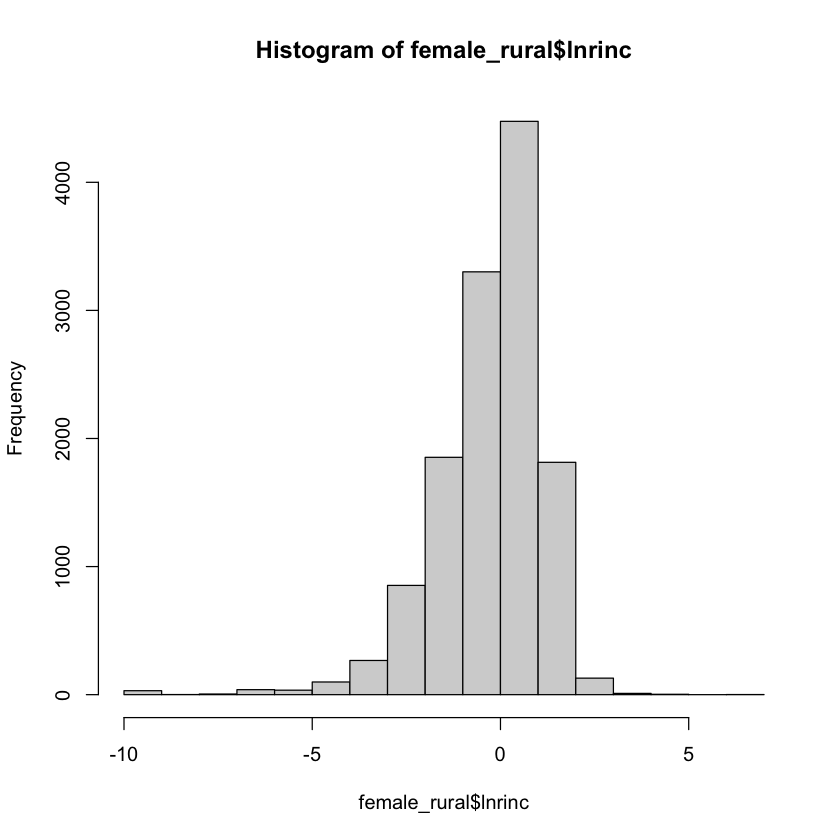

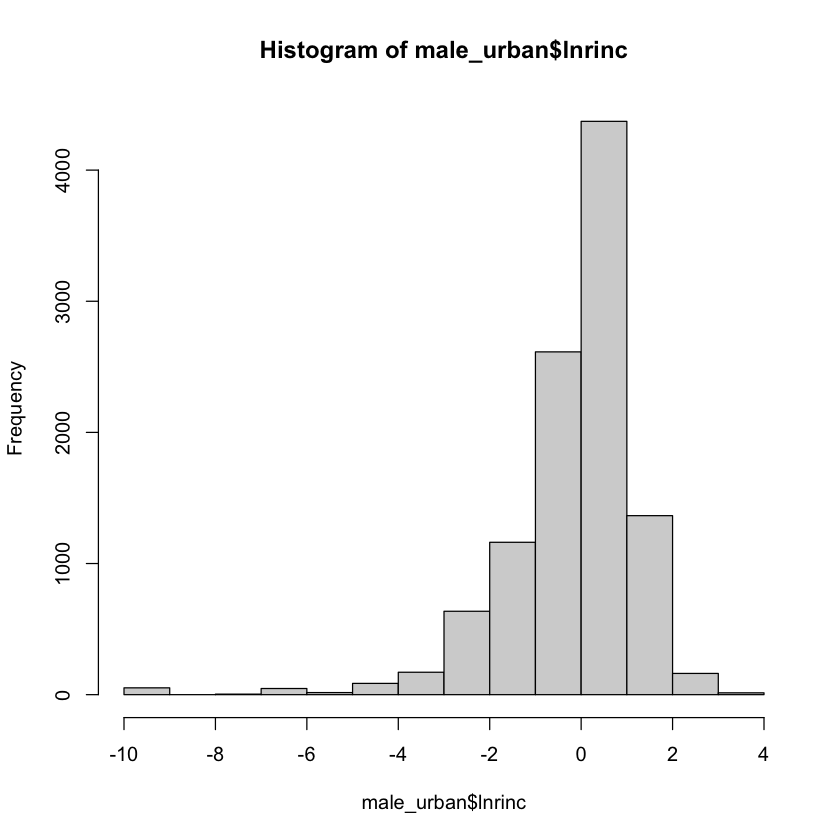

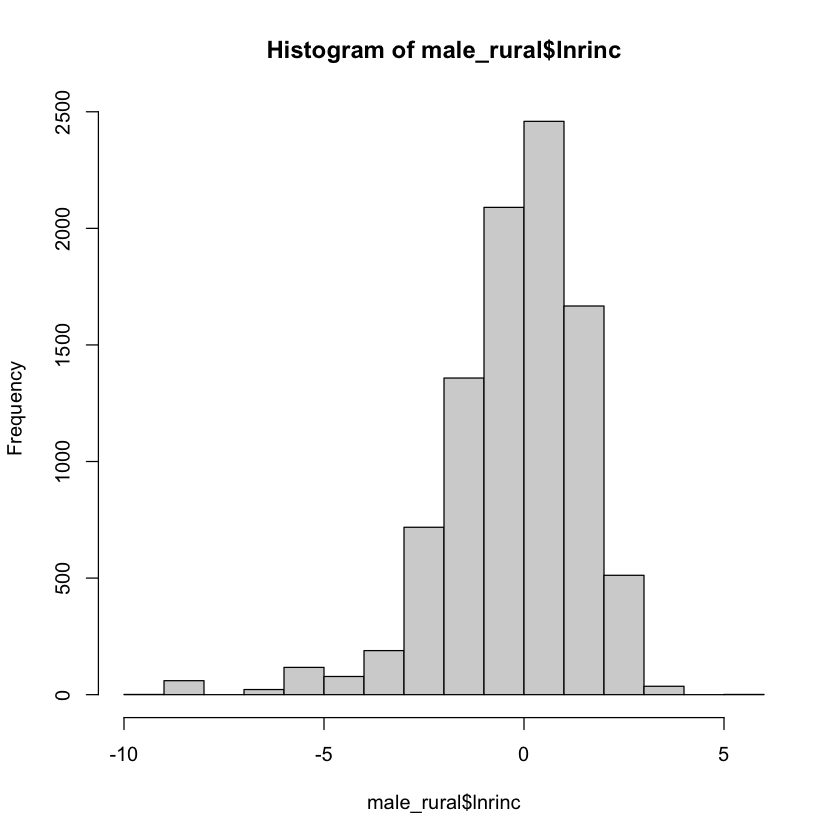

In [37]:
hist(combined$lnrinc)
hist(urban$lnrinc)
hist(rural$lnrinc)
hist(female_urban$lnrinc)
hist(female_rural$lnrinc)
hist(male_urban$lnrinc)
hist(male_rural$lnrinc)

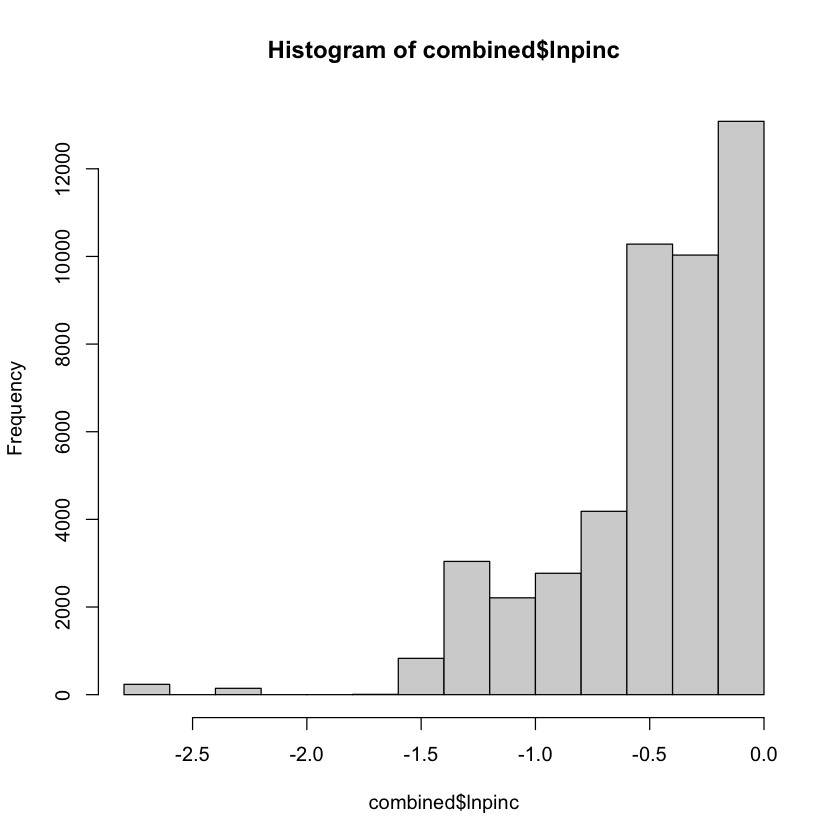

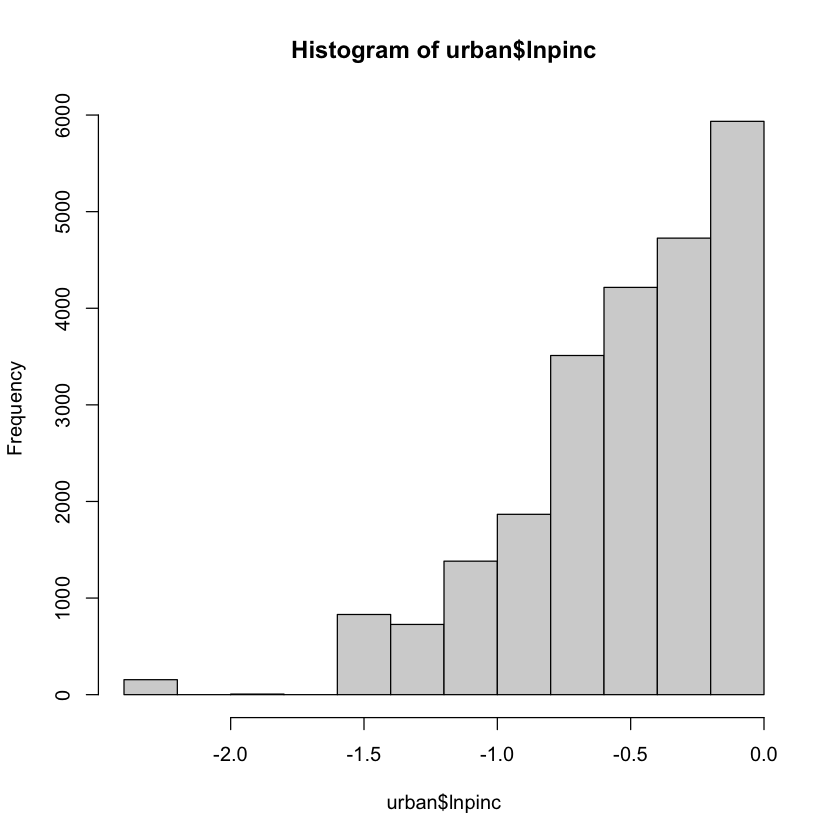

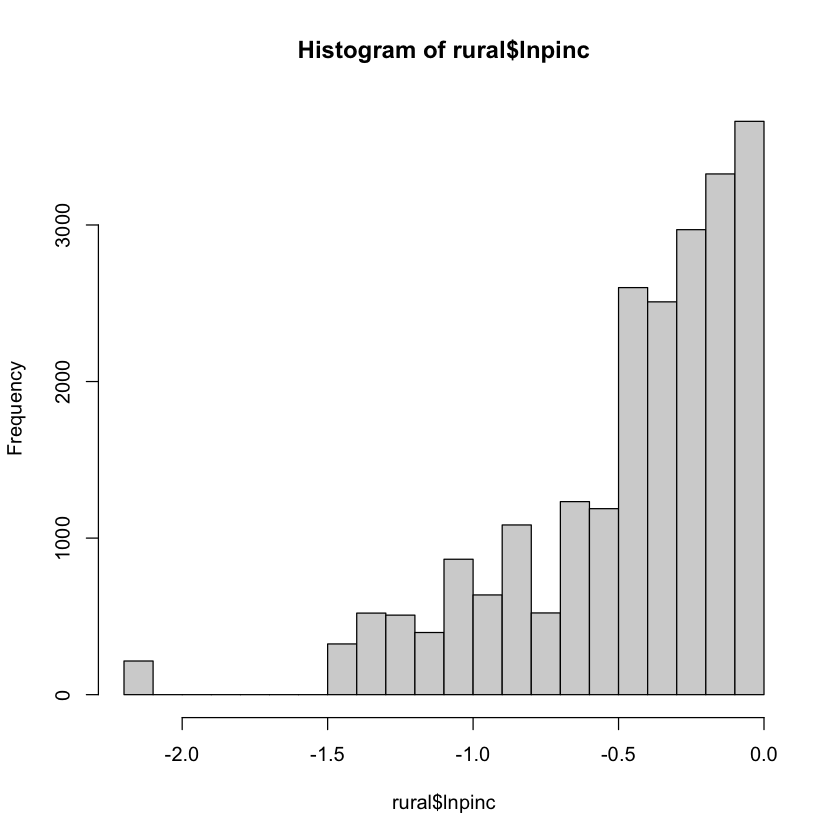

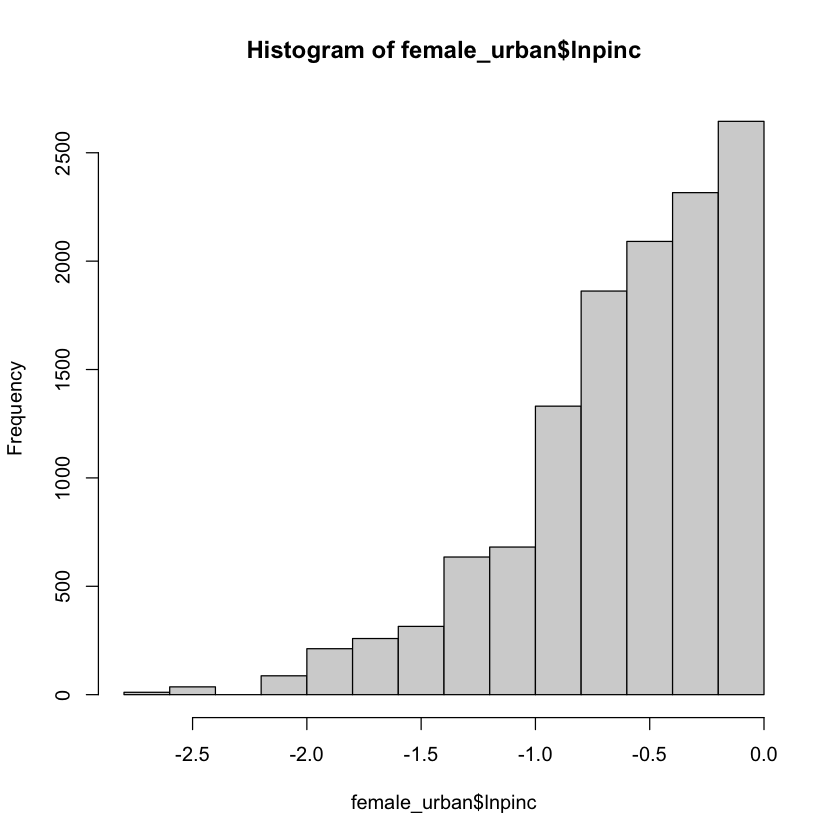

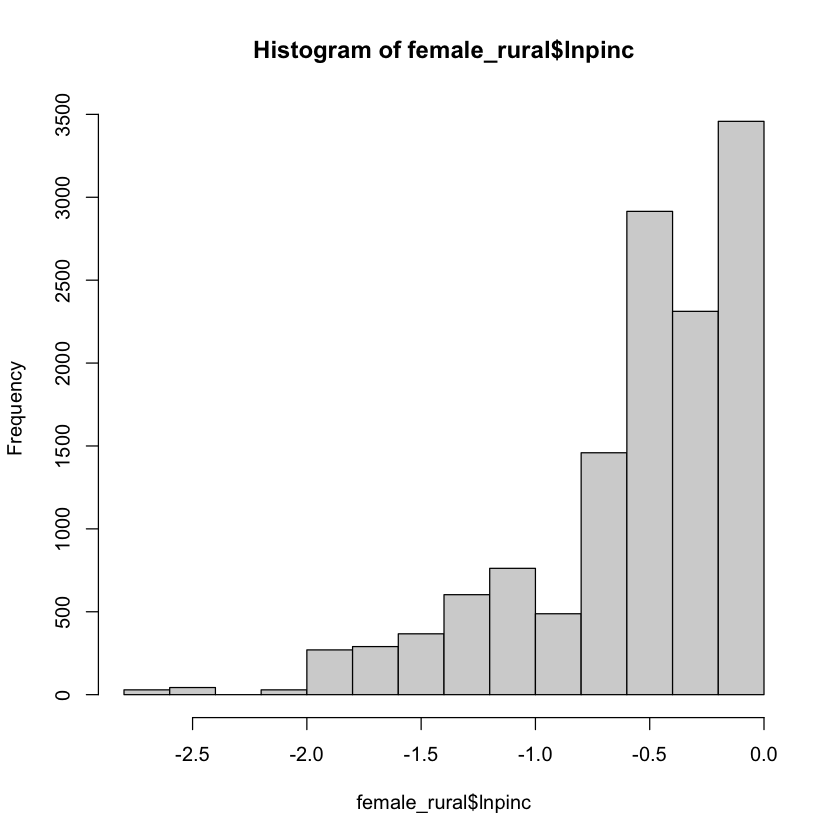

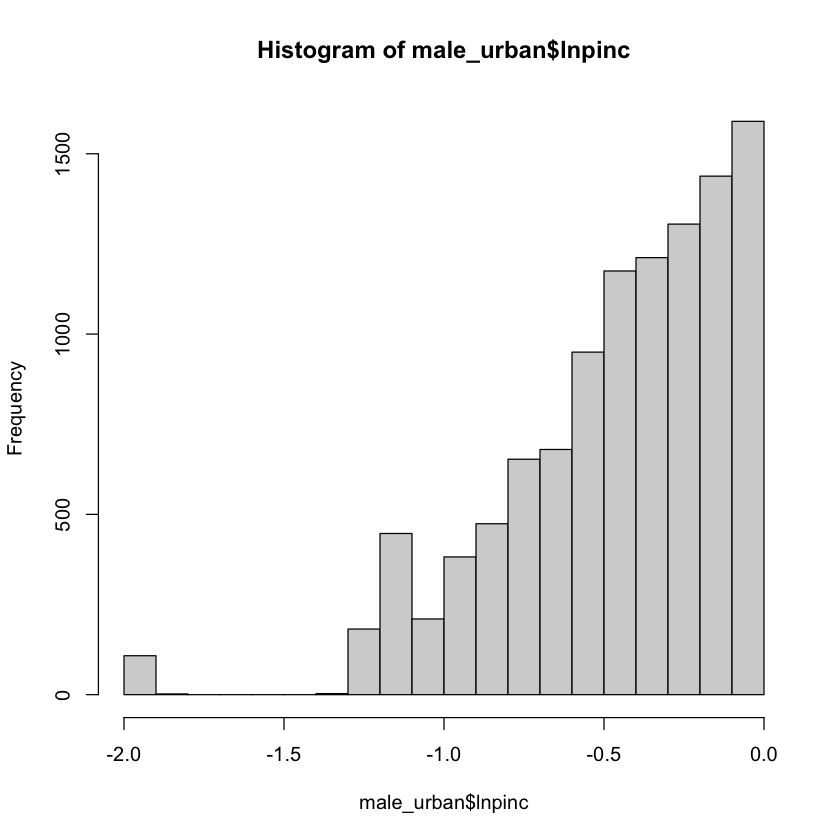

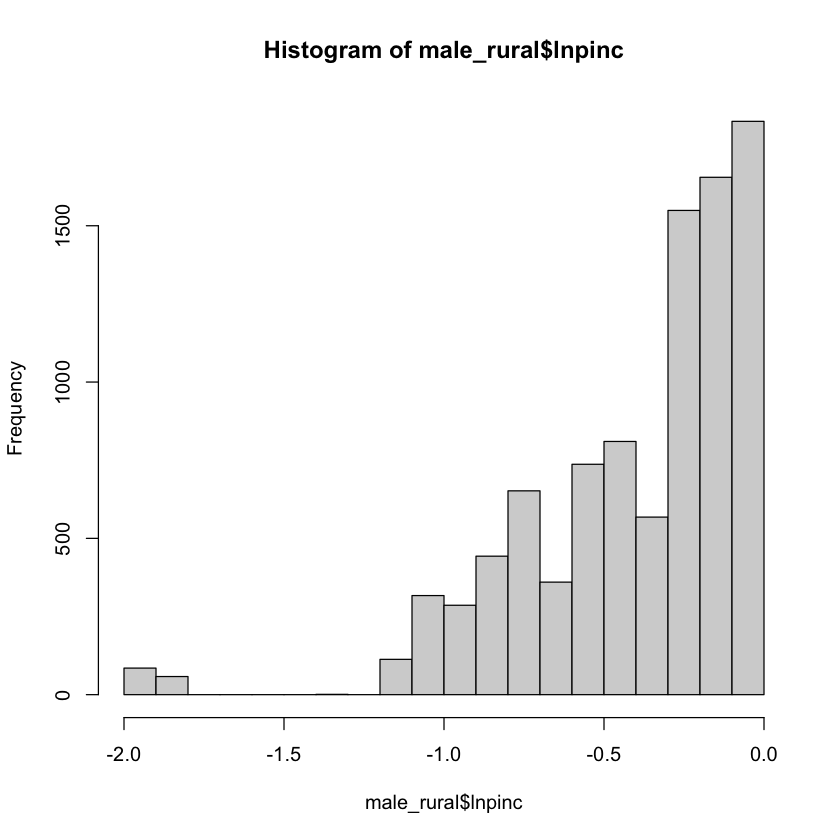

In [38]:
hist(combined$lnpinc)
hist(urban$lnpinc)
hist(rural$lnpinc)
hist(female_urban$lnpinc)
hist(female_rural$lnpinc)
hist(male_urban$lnpinc)
hist(male_rural$lnpinc)

## Running the regressions for lninc, rinc, lnrinc, pinc, and lnpinc on combined data, and urban and rural subsamples. Does not contain married or party variables

### Regression for lninc

In [82]:
lnincReg = filter(combined, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnincReg))

urban_reg = filter(urban, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))

rural_reg = filter(rural, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))

female_urban_reg = filter(female_urban, !is.infinite(lninc) & !is.na(lninc))
female_rural_reg = filter(female_rural, !is.infinite(lninc) & !is.na(lninc))
male_urban_reg = filter(male_urban, !is.infinite(lninc) & !is.na(lninc))
male_rural_reg = filter(male_rural, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = lnincReg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5493  -0.5264   0.2281   0.8410   5.3336 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.797265   0.024534 358.578  < 2e-16 ***
postsecondary    1.732932   0.024212  71.574  < 2e-16 ***
seniorsecondary  1.265809   0.021949  57.670  < 2e-16 ***
juniorsecondary  1.050874   0.018734  56.093  < 2e-16 ***
primary          0.618875   0.020639  29.985  < 2e-16 ***
gender           0.283885   0.009443  30.064  < 2e-16 ***
urban            0.019081   0.005930   3.217  0.00129 ** 
y10             -1.089056   0.021248 -51.255  < 2e-16 ***
y12             -0.446978   0.022283 -20.059  < 2e-16 ***
y14             -1.361638   0.054684 -24.900  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.38


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4944  -0.3971   0.1990   0.6733   4.4564 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.99563    0.03223  279.08   <2e-16 ***
postsecondary    1.49882    0.02997   50.02   <2e-16 ***
seniorsecondary  1.05557    0.02905   36.33   <2e-16 ***
juniorsecondary  0.88624    0.02711   32.70   <2e-16 ***
primary          0.55341    0.03122   17.73   <2e-16 ***
gender           0.24503    0.01227   19.96   <2e-16 ***
y10             -0.80633    0.02533  -31.84   <2e-16 ***
y12             -0.26977    0.02643  -10.21   <2e-16 ***
y14             -1.71081    0.07923  -21.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.242 on 23150 degrees of freedom
Multiple R-squared:  0.1986,	Adjusted R-squar


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8980 -0.6364  0.2286  0.8992  5.5796 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.85449    0.03690  239.93   <2e-16 ***
postsecondary    1.33277    0.05009   26.61   <2e-16 ***
seniorsecondary  1.04356    0.03552   29.38   <2e-16 ***
juniorsecondary  0.94789    0.02609   36.33   <2e-16 ***
primary          0.56980    0.02716   20.98   <2e-16 ***
gender           0.38078    0.01434   26.55   <2e-16 ***
y10             -1.40198    0.03401  -41.23   <2e-16 ***
y12             -0.66265    0.03585  -18.48   <2e-16 ***
y14             -2.65111    0.09400  -28.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.448 on 22284 degrees of freedom
Multiple R-squared:  0.2376,	Adjusted R-squared:  0.237


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4420  -0.3562   0.1734   0.6363   4.4840 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.48845    0.04226 224.499   <2e-16 ***
postsecondary    1.25608    0.04057  30.958   <2e-16 ***
seniorsecondary  0.81127    0.03938  20.601   <2e-16 ***
juniorsecondary  0.72650    0.03710  19.580   <2e-16 ***
primary          0.35789    0.04175   8.572   <2e-16 ***
y10             -0.73316    0.03114 -23.543   <2e-16 ***
y12             -0.30250    0.03248  -9.314   <2e-16 ***
y14             -1.33373    0.09561 -13.950   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.132 on 12387 degrees of freedom
Multiple R-squared:  0.1498,	Adjusted R-squared:  0.1493 
F-statistic: 311.8 on 7 and 12387 DF,  p-value


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5980 -0.5356  0.2405  0.8424  5.6423 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.36113    0.04409  212.31   <2e-16 ***
postsecondary    1.14427    0.06011   19.04   <2e-16 ***
seniorsecondary  0.94628    0.04176   22.66   <2e-16 ***
juniorsecondary  0.85130    0.03236   26.30   <2e-16 ***
primary          0.48013    0.03405   14.10   <2e-16 ***
y10             -1.31387    0.03962  -33.16   <2e-16 ***
y12             -0.61447    0.04153  -14.80   <2e-16 ***
y14             -2.29392    0.11752  -19.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.303 on 12909 degrees of freedom
Multiple R-squared:  0.1981,	Adjusted R-squared:  0.1977 
F-statistic: 455.6 on 7 and 12909 DF,  p-value: < 2.2e-1


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4816  -0.3791   0.2467   0.7425   4.3309 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.84775    0.04812 183.863  < 2e-16 ***
postsecondary    1.63390    0.04424  36.936  < 2e-16 ***
seniorsecondary  1.18685    0.04296  27.625  < 2e-16 ***
juniorsecondary  0.89749    0.03975  22.577  < 2e-16 ***
primary          0.62488    0.04677  13.361  < 2e-16 ***
y10             -0.87725    0.04052 -21.649  < 2e-16 ***
y12             -0.26280    0.04234  -6.207 5.61e-10 ***
y14             -2.19469    0.12995 -16.888  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.332 on 10693 degrees of freedom
Multiple R-squared:  0.2153,	Adjusted R-squared:  0.2148 
F-statistic: 419.1 on 7 and 10693 DF,  p-value: 


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8023 -0.7819  0.3052  1.0189  5.3141 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.81971    0.06140  143.65   <2e-16 ***
postsecondary    1.48068    0.08454   17.52   <2e-16 ***
seniorsecondary  0.98258    0.06398   15.36   <2e-16 ***
juniorsecondary  0.89573    0.04347   20.60   <2e-16 ***
primary          0.53316    0.04422   12.06   <2e-16 ***
y10             -1.52397    0.05906  -25.80   <2e-16 ***
y12             -0.83170    0.06301  -13.20   <2e-16 ***
y14             -3.00963    0.14965  -20.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 9300 degrees of freedom
Multiple R-squared:  0.1971,	Adjusted R-squared:  0.1965 
F-statistic: 326.2 on 7 and 9300 DF,  p-value: < 2.2e-16


In [83]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lninc = c(mean(lnincReg$lninc), mean(urban_reg$lninc), mean(rural_reg$lninc), mean(female_urban_reg$lninc), mean(female_rural_reg$lninc), mean(male_urban_reg$lninc), mean(male_rural_reg$lninc))
median_lninc = c(median(lnincReg$lninc), median(urban_reg$lninc), median(rural_reg$lninc), median(female_urban_reg$lninc), median(female_rural_reg$lninc), median(male_urban_reg$lninc), median(male_rural_reg$lninc))
var_lninc = c(var(lnincReg$lninc), var(urban_reg$lninc), var(rural_reg$lninc), var(female_urban_reg$lninc), var(female_rural_reg$lninc), var(male_urban_reg$lninc), var(male_rural_reg$lninc))
kurtosis_lninc = c(kurtosis(lnincReg$lninc), kurtosis(urban_reg$lninc), kurtosis(rural_reg$lninc), kurtosis(female_urban_reg$lninc), kurtosis(female_rural_reg$lninc), kurtosis(male_urban_reg$lninc), kurtosis(male_rural_reg$lninc))
skew_lninc = c(skewness(lnincReg$lninc), skewness(urban_reg$lninc), skewness(rural_reg$lninc), skewness(female_urban_reg$lninc), skewness(female_rural_reg$lninc), skewness(male_urban_reg$lninc), skewness(male_rural_reg$lninc))

lninc = data.frame("subsamples"=index, "mean" = mean_lninc, "median" = median_lninc, "var" = var_lninc, "kurtosis" = kurtosis_lninc, "skew" = skew_lninc)
lninc$stdev = sqrt(lninc$var)

In [84]:
print("Lninc descriptive statistics")
print(lninc)

[1] "Lninc descriptive statistics"
    subsamples     mean   median      var kurtosis      skew    stdev
1     combined 9.061718 9.392662 2.511959 5.009130 -1.613858 1.584916
2        urban 9.468470 9.784704 1.923729 8.769189 -2.052226 1.386986
3        rural 8.621783 8.922658 2.748698 3.659157 -1.353109 1.657920
4 female_urban 9.714591 9.903488 1.506458 8.792632 -1.866556 1.227378
5 female_rural 9.000477 9.210340 2.116679 4.794995 -1.445970 1.454881
6   male_urban 9.180661 9.510445 2.259995 8.187224 -2.114384 1.503328
7   male_rural 8.096532 8.294050 3.157891 2.919475 -1.226031 1.777046


### Regression for rinc and lnrinc

In [85]:
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=combined))
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban))
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural))

lnrincReg = filter(combined, !is.infinite(lnrinc) & !is.na(lnrinc))
urban_reg = filter(urban, !is.infinite(lnrinc) & !is.na(lnrinc))
rural_reg = filter(rural, !is.infinite(lnrinc) & !is.na(lnrinc))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnrincReg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))


female_urban_reg = filter(female_urban, !is.infinite(lnrinc) & !is.na(lnrinc))
female_rural_reg = filter(female_rural, !is.infinite(lnrinc) & !is.na(lnrinc))
male_urban_reg = filter(male_urban, !is.infinite(lnrinc) & !is.na(lnrinc))
male_rural_reg = filter(male_rural, !is.infinite(lnrinc) & !is.na(lnrinc))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))


Call:
lm(formula = rinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = combined)

Residuals:
   Min     1Q Median     3Q    Max 
 -3.07  -0.82  -0.30   0.33 467.73 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.145090   0.037147   3.906 9.40e-05 ***
postsecondary   2.432263   0.040480  60.085  < 2e-16 ***
seniorsecondary 0.958014   0.033858  28.295  < 2e-16 ***
juniorsecondary 0.645283   0.027834  23.183  < 2e-16 ***
primary         0.284256   0.030755   9.243  < 2e-16 ***
gender          0.265572   0.014158  18.758  < 2e-16 ***
urban           0.048417   0.009626   5.030 4.92e-07 ***
y10             0.157319   0.034876   4.511 6.47e-06 ***
y12             0.069476   0.034995   1.985   0.0471 *  
y14             0.181437   0.084498   2.147   0.0318 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.829 on 75874 degrees of freedom
Mu


Call:
lm(formula = rinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.450  -0.743  -0.265   0.380 188.883 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.21874    0.04170   5.245 1.57e-07 ***
postsecondary    1.80552    0.04014  44.985  < 2e-16 ***
seniorsecondary  0.70692    0.03706  19.073  < 2e-16 ***
juniorsecondary  0.46760    0.03383  13.823  < 2e-16 ***
primary          0.21756    0.03923   5.546 2.95e-08 ***
gender           0.27539    0.01648  16.711  < 2e-16 ***
y10              0.08581    0.03592   2.389   0.0169 *  
y12              0.04192    0.03626   1.156   0.2477    
y14              0.15057    0.10123   1.487   0.1369    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.065 on 34502 degrees of freedom
Multiple R-squared:  0.07593,	Adjusted R-squared:  0.07572 



Call:
lm(formula = rinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural)

Residuals:
   Min     1Q Median     3Q    Max 
 -3.19  -0.97  -0.39   0.19 590.63 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.21328    0.06516   3.273  0.00106 ** 
postsecondary    2.45692    0.10378  23.674  < 2e-16 ***
seniorsecondary  1.06649    0.06634  16.075  < 2e-16 ***
juniorsecondary  0.85660    0.04706  18.201  < 2e-16 ***
primary          0.38029    0.04912   7.742    1e-14 ***
gender           0.32190    0.02420  13.299  < 2e-16 ***
y10              0.18160    0.06425   2.826  0.00471 ** 
y12              0.04979    0.06418   0.776  0.43791    
y14              0.19706    0.16908   1.165  0.24383    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.67 on 40329 degrees of freedom
Multiple R-squared:  0.027,	Adjusted R-squared:  0.02681 
F-statistic: 


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = lnrincReg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5493  -0.5264   0.2281   0.8410   5.3336 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.196444   0.024534 -48.767  < 2e-16 ***
postsecondary    1.732932   0.024212  71.574  < 2e-16 ***
seniorsecondary  1.265809   0.021949  57.670  < 2e-16 ***
juniorsecondary  1.050874   0.018734  56.093  < 2e-16 ***
primary          0.618875   0.020639  29.985  < 2e-16 ***
gender           0.283885   0.009443  30.064  < 2e-16 ***
urban            0.019081   0.005930   3.217  0.00129 ** 
y10             -0.268313   0.021248 -12.628  < 2e-16 ***
y12              0.239660   0.022283  10.755  < 2e-16 ***
y14             -0.711340   0.054684 -13.008  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4944  -0.3971   0.1990   0.6733   4.4564 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.17861    0.03223 -36.565  < 2e-16 ***
postsecondary    1.49882    0.02997  50.017  < 2e-16 ***
seniorsecondary  1.05557    0.02905  36.331  < 2e-16 ***
juniorsecondary  0.88624    0.02711  32.696  < 2e-16 ***
primary          0.55341    0.03122  17.727  < 2e-16 ***
gender           0.24503    0.01227  19.965  < 2e-16 ***
y10             -0.15038    0.02533  -5.937 2.94e-09 ***
y12              0.23186    0.02643   8.772  < 2e-16 ***
y14             -0.85036    0.07923 -10.732  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.242 on 23150 degrees of freedom
Multiple R-squared:  0.157,	Adjusted R-squar


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8980 -0.6364  0.2286  0.8992  5.5796 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.90691    0.03690 -24.574  < 2e-16 ***
postsecondary    1.33277    0.05009  26.608  < 2e-16 ***
seniorsecondary  1.04356    0.03552  29.379  < 2e-16 ***
juniorsecondary  0.94789    0.02609  36.330  < 2e-16 ***
primary          0.56980    0.02716  20.977  < 2e-16 ***
gender           0.38078    0.01434  26.549  < 2e-16 ***
y10             -0.37282    0.03401 -10.963  < 2e-16 ***
y12              0.25815    0.03585   7.201 6.19e-13 ***
y14             -1.53415    0.09400 -16.321  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.448 on 22284 degrees of freedom
Multiple R-squared:  0.1802,	Adjusted R-squared:  0.17


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4420  -0.3562   0.1734   0.6363   4.4840 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.86855    0.04226 -20.550  < 2e-16 ***
postsecondary    1.25608    0.04057  30.958  < 2e-16 ***
seniorsecondary  0.81127    0.03938  20.601  < 2e-16 ***
juniorsecondary  0.72650    0.03710  19.580  < 2e-16 ***
primary          0.35789    0.04175   8.572  < 2e-16 ***
y10             -0.17512    0.03114  -5.623 1.91e-08 ***
y12              0.10011    0.03248   3.083  0.00206 ** 
y14             -0.64754    0.09561  -6.773 1.32e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.132 on 12387 degrees of freedom
Multiple R-squared:  0.1082,	Adjusted R-squared:  0.1077 
F-statistic: 214.6 on 7 and 12387 DF,  p-valu


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5980 -0.5356  0.2405  0.8424  5.6423 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.68634    0.04409 -15.566  < 2e-16 ***
postsecondary    1.14427    0.06011  19.037  < 2e-16 ***
seniorsecondary  0.94628    0.04176  22.658  < 2e-16 ***
juniorsecondary  0.85130    0.03236  26.304  < 2e-16 ***
primary          0.48013    0.03405  14.101  < 2e-16 ***
y10             -0.34551    0.03962  -8.721  < 2e-16 ***
y12              0.17754    0.04153   4.275 1.92e-05 ***
y14             -1.26564    0.11752 -10.769  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.303 on 12909 degrees of freedom
Multiple R-squared:  0.1263,	Adjusted R-squared:  0.1258 
F-statistic: 266.6 on 7 and 12909 DF,  p-value: < 2.2e-


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4816  -0.3791   0.2467   0.7425   4.3309 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.06522    0.04812 -22.136  < 2e-16 ***
postsecondary    1.63390    0.04424  36.936  < 2e-16 ***
seniorsecondary  1.18685    0.04296  27.625  < 2e-16 ***
juniorsecondary  0.89749    0.03975  22.577  < 2e-16 ***
primary          0.62488    0.04677  13.361  < 2e-16 ***
y10             -0.12950    0.04052  -3.196   0.0014 ** 
y12              0.33580    0.04234   7.931 2.39e-15 ***
y14             -0.98714    0.12995  -7.596 3.31e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.332 on 10693 degrees of freedom
Multiple R-squared:  0.1687,	Adjusted R-squared:  0.1682 
F-statistic: 310.1 on 7 and 10693 DF,  p-value:


Call:
lm(formula = lnrinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8023 -0.7819  0.3052  1.0189  5.3141 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.41054    0.06140  -6.687 2.41e-11 ***
postsecondary    1.48068    0.08454  17.515  < 2e-16 ***
seniorsecondary  0.98258    0.06398  15.358  < 2e-16 ***
juniorsecondary  0.89573    0.04347  20.604  < 2e-16 ***
primary          0.53316    0.04422  12.057  < 2e-16 ***
y10             -0.51795    0.05906  -8.770  < 2e-16 ***
y12              0.24681    0.06301   3.917 9.04e-05 ***
y14             -1.94384    0.14965 -12.990  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 9300 degrees of freedom
Multiple R-squared:  0.1534,	Adjusted R-squared:  0.1528 
F-statistic: 240.8 on 7 and 9300 DF,  p-value: < 2.2e-16


In [86]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lnrinc = c(mean(lnrincReg$lnrinc), mean(urban_reg$lnrinc), mean(rural_reg$lnrinc), mean(female_urban_reg$lnrinc), mean(female_rural_reg$lnrinc), mean(male_urban_reg$lnrinc), mean(male_rural_reg$lnrinc))
median_lnrinc = c(median(lnrincReg$lnrinc), median(urban_reg$lnrinc), median(rural_reg$lnrinc), median(female_urban_reg$lnrinc), median(female_rural_reg$lnrinc), median(male_urban_reg$lnrinc), median(male_rural_reg$lnrinc))
var_lnrinc = c(var(lnincReg$lnrinc), var(urban_reg$lnrinc), var(rural_reg$lnrinc), var(female_urban_reg$lnrinc), var(female_rural_reg$lnrinc), var(male_urban_reg$lnrinc), var(male_rural_reg$lnrinc))
kurtosis_lnrinc = c(kurtosis(lnrincReg$lnrinc), kurtosis(urban_reg$lnrinc), kurtosis(rural_reg$lnrinc), kurtosis(female_urban_reg$lnrinc), kurtosis(female_rural_reg$lnrinc), kurtosis(male_urban_reg$lnrinc), kurtosis(male_rural_reg$lnrinc))
skew_lnrinc = c(skewness(lnrincReg$lnrinc), skewness(urban_reg$lnrinc), skewness(rural_reg$lnrinc), skewness(female_urban_reg$lnrinc), skewness(female_rural_reg$lnrinc), skewness(male_urban_reg$lnrinc), skewness(male_rural_reg$lnrinc))

lnrinc = data.frame("subsamples"=index, "mean" = mean_lnrinc, "median" = median_lnrinc, "var" = var_lnrinc, "kurtosis" = kurtosis_lnrinc, "skew" = skew_lnrinc)
lnrinc$stdev = sqrt(lnrinc$var)

In [87]:
print("Lnrinc descriptive statistics")
print(lnrinc)

[1] "Lnrinc descriptive statistics"
    subsamples       mean        median      var kurtosis      skew    stdev
1     combined -0.2511354  0.0423579142 2.372562 5.466601 -1.682631 1.540312
2        urban -0.1876165  0.0975059813 1.828876 9.320405 -2.110265 1.352360
3        rural -0.2417481  0.0130572746 2.556404 4.085058 -1.425694 1.598876
4 female_urban -0.2135129 -0.0008291416 1.436125 9.551798 -1.948407 1.198384
5 female_rural -0.2321247  0.0258722533 1.942778 5.430126 -1.552104 1.393836
6   male_urban -0.1255579  0.2274507868 2.133439 8.687825 -2.160633 1.460630
7   male_rural -0.2034469  0.0369568992 2.994819 3.249922 -1.277776 1.730555


### Regression for pinc and lnpinc

In [39]:
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=combined))
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban))
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural))

lnpincReg = filter(combined, !is.infinite(lnpinc) & !is.na(lnpinc))
urban_reg = filter(urban, !is.infinite(lnpinc) & !is.na(lnpinc))
rural_reg = filter(rural, !is.infinite(lnpinc) & !is.na(lnpinc))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnpincReg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))


female_urban_reg = filter(female_urban, !is.infinite(lnpinc) & !is.na(lnpinc))
female_rural_reg = filter(female_rural, !is.infinite(lnpinc) & !is.na(lnpinc))
male_urban_reg = filter(male_urban, !is.infinite(lnpinc) & !is.na(lnpinc))
male_rural_reg = filter(male_rural, !is.infinite(lnpinc) & !is.na(lnpinc))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))


Call:
lm(formula = pinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = combined)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78300 -0.28505  0.00969  0.27843  1.21709 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.209544   0.004314   48.57   <2e-16 ***
postsecondary    0.429410   0.004707   91.22   <2e-16 ***
seniorsecondary  0.274164   0.003993   68.66   <2e-16 ***
juniorsecondary  0.210421   0.003258   64.58   <2e-16 ***
primary          0.117429   0.003585   32.75   <2e-16 ***
gender           0.058640   0.001650   35.53   <2e-16 ***
urban            0.009901   0.001119    8.85   <2e-16 ***
y10              0.075506   0.004068   18.56   <2e-16 ***
y12             -0.062002   0.004059  -15.28   <2e-16 ***
y14              0.117592   0.009804   11.99   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.328


Call:
lm(formula = pinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72810 -0.26685  0.04645  0.25229  1.18198 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.232509   0.006417  36.236  < 2e-16 ***
postsecondary    0.396438   0.006180  64.154  < 2e-16 ***
seniorsecondary  0.241466   0.005756  41.949  < 2e-16 ***
juniorsecondary  0.179308   0.005234  34.260  < 2e-16 ***
primary          0.098847   0.006045  16.353  < 2e-16 ***
gender           0.064816   0.002548  25.438  < 2e-16 ***
y10              0.034341   0.005551   6.186 6.25e-10 ***
y12             -0.045222   0.005572  -8.116 4.99e-16 ***
y14              0.091783   0.015554   5.901 3.65e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3173 on 33726 degrees of freedom
Multiple R-squared:  0.152,	Adjusted R-


Call:
lm(formula = pinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.77934 -0.31995 -0.05145  0.30548  1.21080 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.207935   0.006059  34.316   <2e-16 ***
postsecondary    0.393705   0.009669  40.719   <2e-16 ***
seniorsecondary  0.252580   0.006316  39.988   <2e-16 ***
juniorsecondary  0.214079   0.004420  48.433   <2e-16 ***
primary          0.126182   0.004592  27.477   <2e-16 ***
gender           0.064133   0.002258  28.400   <2e-16 ***
y10              0.113566   0.005999  18.930   <2e-16 ***
y12             -0.078305   0.005959 -13.140   <2e-16 ***
y14              0.155325   0.015699   9.894   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3408 on 39472 degrees of freedom
Multiple R-squared:  0.1548,	Adjusted R


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = lnpincReg)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9708 -0.1924  0.0406  0.2331  1.0658 

Coefficients:
                 Estimate Std. Error  t value Pr(>|t|)    
(Intercept)     -0.746794   0.006119 -122.047  < 2e-16 ***
postsecondary    0.480938   0.005994   80.237  < 2e-16 ***
seniorsecondary  0.365042   0.005443   67.071  < 2e-16 ***
juniorsecondary  0.295350   0.004638   63.683  < 2e-16 ***
primary          0.184935   0.005110   36.192  < 2e-16 ***
gender           0.069093   0.002355   29.336  < 2e-16 ***
urban           -0.004120   0.001328   -3.104  0.00191 ** 
y10             -0.105474   0.005318  -19.833  < 2e-16 ***
y12              0.142442   0.005576   25.543  < 2e-16 ***
y14             -0.479300   0.011047  -43.386  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.94327 -0.21167  0.04866  0.25451  1.17215 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.858395   0.009108 -94.243  < 2e-16 ***
postsecondary    0.494578   0.008453  58.512  < 2e-16 ***
seniorsecondary  0.348333   0.008195  42.505  < 2e-16 ***
juniorsecondary  0.273021   0.007631  35.776  < 2e-16 ***
primary          0.165801   0.008778  18.888  < 2e-16 ***
gender           0.078527   0.003479  22.575  < 2e-16 ***
y10             -0.058791   0.007195  -8.171  3.2e-16 ***
y12              0.152817   0.007509  20.352  < 2e-16 ***
y14             -0.314787   0.017675 -17.810  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3528 on 23346 degrees of freedom
Multiple R-squared:  0.2491,	Adju


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7540 -0.1689  0.0338  0.2128  0.9589 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.590807   0.008579  -68.87   <2e-16 ***
postsecondary    0.328555   0.011623   28.27   <2e-16 ***
seniorsecondary  0.274364   0.008241   33.29   <2e-16 ***
juniorsecondary  0.242901   0.006040   40.21   <2e-16 ***
primary          0.166511   0.006276   26.53   <2e-16 ***
gender           0.080207   0.003332   24.07   <2e-16 ***
y10             -0.182905   0.007923  -23.09   <2e-16 ***
y12              0.122014   0.008354   14.61   <2e-16 ***
y14             -0.488361   0.016368  -29.84   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3374 on 22552 degrees of freedom
Multiple R-squared:  0.3024,	Adjusted R-squ


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.32418 -0.25183  0.07827  0.30848  1.04970 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.89452    0.01612 -55.477  < 2e-16 ***
postsecondary    0.58657    0.01545  37.966  < 2e-16 ***
seniorsecondary  0.39679    0.01499  26.463  < 2e-16 ***
juniorsecondary  0.33259    0.01411  23.578  < 2e-16 ***
primary          0.17802    0.01587  11.218  < 2e-16 ***
y10             -0.16108    0.01196 -13.474  < 2e-16 ***
y12              0.10026    0.01247   8.041  9.7e-16 ***
y14             -0.34799    0.03008 -11.568  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4346 on 12473 degrees of freedom
Multiple R-squared:  0.2042,	Adjusted R-squared:  0.2037 
F-statistic: 457.2 on 7 and 12473 DF,  p-val


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_rural_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.16085 -0.21904  0.05718  0.28794  1.07154 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.63634    0.01447 -43.974  < 2e-16 ***
postsecondary    0.40970    0.01969  20.809  < 2e-16 ***
seniorsecondary  0.35848    0.01368  26.199  < 2e-16 ***
juniorsecondary  0.31699    0.01058  29.955  < 2e-16 ***
primary          0.20395    0.01112  18.336  < 2e-16 ***
y10             -0.29758    0.01303 -22.832  < 2e-16 ***
y12              0.06391    0.01366   4.678 2.93e-06 ***
y14             -0.50083    0.02997 -16.708  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4288 on 13017 degrees of freedom
Multiple R-squared:  0.2482,	Adjusted R-squared:  0.2478 
F-statistic:   614 on 7 and 13017 DF,  p-val


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_urban_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6697 -0.1840  0.0450  0.2179  0.9343 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.738348   0.011038 -66.894   <2e-16 ***
postsecondary    0.425859   0.010130  42.041   <2e-16 ***
seniorsecondary  0.305000   0.009839  30.998   <2e-16 ***
juniorsecondary  0.212511   0.009085  23.393   <2e-16 ***
primary          0.138876   0.010660  13.028   <2e-16 ***
y10              0.004036   0.009332   0.433    0.665    
y12              0.179373   0.009752  18.393   <2e-16 ***
y14             -0.298854   0.022332 -13.383   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3068 on 10803 degrees of freedom
Multiple R-squared:  0.2573,	Adjusted R-squared:  0.2569 
F-statistic: 534.8 on 7 and 10803 DF,  p-value:


Call:
lm(formula = lnpinc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_rural_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44786 -0.17154  0.01782  0.19322  0.87377 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.447903   0.011448  -39.12   <2e-16 ***
postsecondary    0.260462   0.015738   16.55   <2e-16 ***
seniorsecondary  0.190066   0.011896   15.98   <2e-16 ***
juniorsecondary  0.173986   0.008071   21.56   <2e-16 ***
primary          0.122070   0.008181   14.92   <2e-16 ***
y10             -0.122530   0.011032  -11.11   <2e-16 ***
y12              0.158215   0.011774   13.44   <2e-16 ***
y14             -0.525133   0.020340  -25.82   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2976 on 9460 degrees of freedom
Multiple R-squared:  0.2888,	Adjusted R-squared:  0.2882 
F-statistic: 548.7 on 7 and 9460 DF,  

In [34]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lnpinc = c(mean(lnpincReg$lnpinc), mean(urban_reg$lnpinc), mean(rural_reg$lnpinc), mean(female_urban_reg$lnpinc), mean(female_rural_reg$lnpinc), mean(male_urban_reg$lnpinc), mean(male_rural_reg$lnpinc))
median_lnpinc = c(median(lnpincReg$lnpinc), median(urban_reg$lnpinc), median(rural_reg$lnpinc), median(female_urban_reg$lnpinc), median(female_rural_reg$lnpinc), median(male_urban_reg$lnpinc), median(male_rural_reg$lnpinc))
var_lnpinc = c(var(lnpincReg$lnpinc), var(urban_reg$lnpinc), var(rural_reg$lnpinc), var(female_urban_reg$lnpinc), var(female_rural_reg$lnpinc), var(male_urban_reg$lnpinc), var(male_rural_reg$lnpinc))
kurtosis_lnpinc = c(kurtosis(lnpincReg$lnpinc), kurtosis(urban_reg$lnpinc), kurtosis(rural_reg$lnpinc), kurtosis(female_urban_reg$lnpinc), kurtosis(female_rural_reg$lnpinc), kurtosis(male_urban_reg$lnpinc), kurtosis(male_rural_reg$lnpinc))
skew_lnpinc = c(skewness(lnpincReg$lnpinc), skewness(urban_reg$lnpinc), skewness(rural_reg$lnpinc), skewness(female_urban_reg$lnpinc), skewness(female_rural_reg$lnpinc), skewness(male_urban_reg$lnpinc), skewness(male_rural_reg$lnpinc))

lnpinc = data.frame("subsamples"=index, "mean" = mean_lnpinc, "median" = median_lnpinc, "var" = var_lnpinc, "kurtosis" = kurtosis_lnpinc, "skew" = skew_lnpinc)
lnpinc$stdev = sqrt(lnpinc$var)

In [35]:
print("Lnpinc descriptive statistics")
print(lnpinc)

[1] "Lnpinc descriptive statistics"
    subsamples       mean     median       var kurtosis      skew     stdev
1     combined -0.4929644 -0.4137467 0.1729911 3.460895 -1.504673 0.4159220
2        urban -0.5239991 -0.4371708 0.1657071 1.414272 -1.098564 0.4070714
3        rural -0.4672305 -0.3412846 0.1631424 1.812138 -1.317396 0.4039089
4 female_urban -0.6097785 -0.4938689 0.2372013 1.098065 -1.111018 0.4870332
5 female_rural -0.5606974 -0.4242731 0.2443960 1.507585 -1.342581 0.4943642
6   male_urban -0.4587463 -0.3767322 0.1266873 2.115663 -1.204974 0.3559316
7   male_rural -0.4020730 -0.2807868 0.1244622 2.958936 -1.463058 0.3527921
